# Clustering 

elbow method, silhouette score, calinski-harabasz e davies-bouldin

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster Models
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

# Metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

In [2]:
df = pd.read_csv('../data/clusterization.csv')
print(df.shape)
df.head()

(15000, 10)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.788532,1.514571,1.965787,1.788532,1.839011,0.027213,4.287439,1.103957,0.272501,0.390037
1,1.137568,-0.537787,0.405860,1.137568,1.177157,0.881743,2.289545,-0.427406,-0.227506,0.452705
2,0.861253,2.133148,-1.285062,0.861253,1.654487,0.104453,-0.858607,0.455393,-1.066773,-0.382173
3,1.630619,-0.000408,0.688288,1.630619,2.688988,2.321262,1.977060,0.234256,-1.424967,-0.864576
4,2.339800,-3.593987,-4.507650,2.339800,-3.642843,0.772287,2.938295,1.424821,-0.171201,4.652432


# EDA

### Distribuições das Variáveis

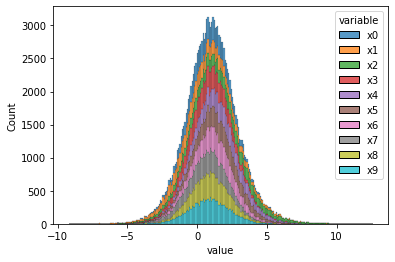

In [3]:
def plot_histogram(df, value_vars):
    df = df.copy()
    df['Index'] = np.arange(len(df))
    df = pd.melt(df, id_vars=['Index'], value_vars=value_vars)
    sns.histplot(df,
                x="value", hue="variable", multiple="stack")

plot_histogram(df, value_vars=df.columns.to_list())

array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>],
       [<AxesSubplot:title={'center':'x3'}>,
        <AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>],
       [<AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>],
       [<AxesSubplot:title={'center':'x9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

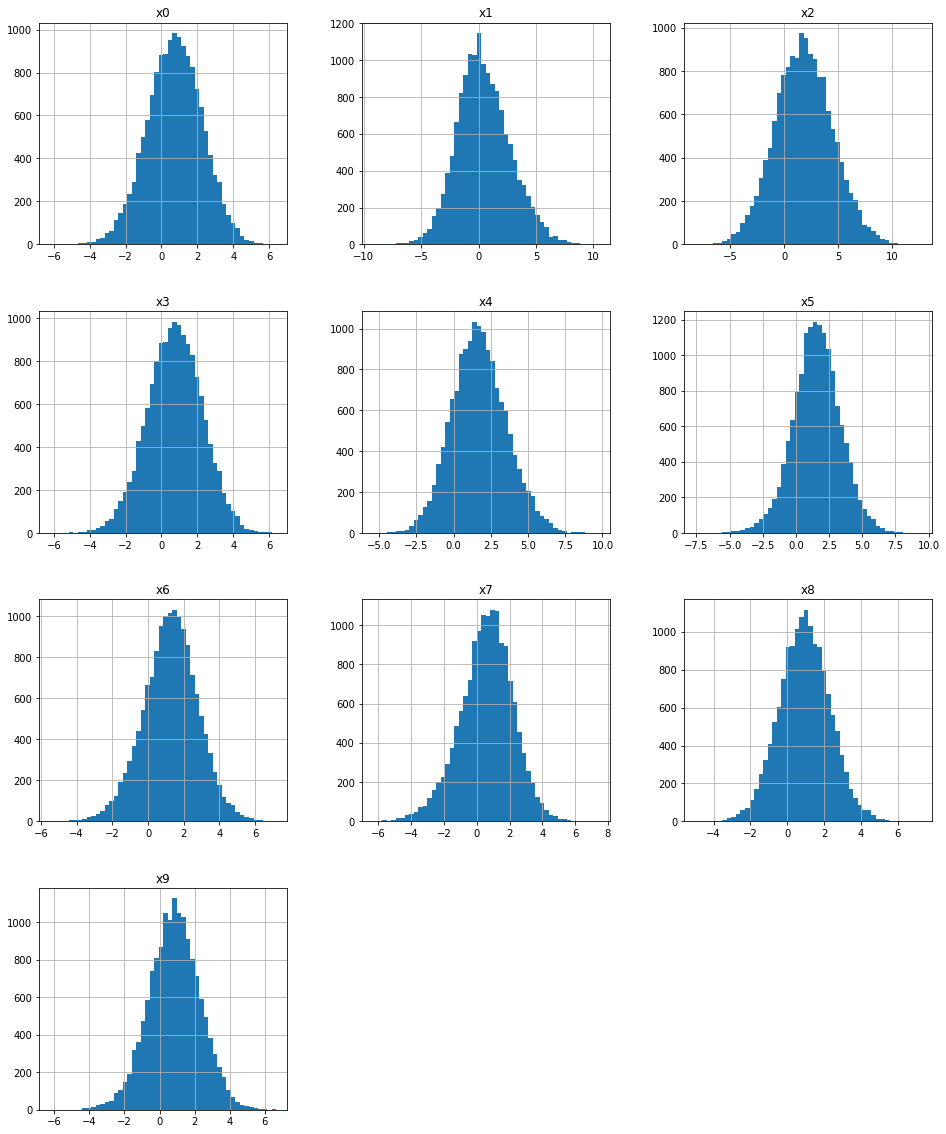

In [4]:
df.hist(figsize=(16, 20), bins=50)

In [30]:
print('Mean')
display(df.mean())
print('\n')
print('Variance')
display(df.var())

Mean


x0    0.742252
x1    0.475308
x2    1.836206
x3    0.742252
x4    1.725555
x5    1.553581
x6    1.272966
x7    0.575115
x8    0.938788
x9    0.852863
dtype: float64



Variance


x0    2.334951
x1    5.428668
x2    6.993753
x3    2.334951
x4    3.376859
x5    3.204161
x6    2.364671
x7    2.640662
x8    1.895128
x9    2.142575
dtype: float64

Como podemos ver, aparentemente todas as variáveis tem distribuições com esse caráter Gaussiano ou Normal. Todas com o mesmo grau de escala, com os dados concentrados em -5 a 5, com média perto de 1 ou 0, e variâncias concentradas em valores pertos de 2. De fato, tem caráter parecidos.

### Correlação

<AxesSubplot:>

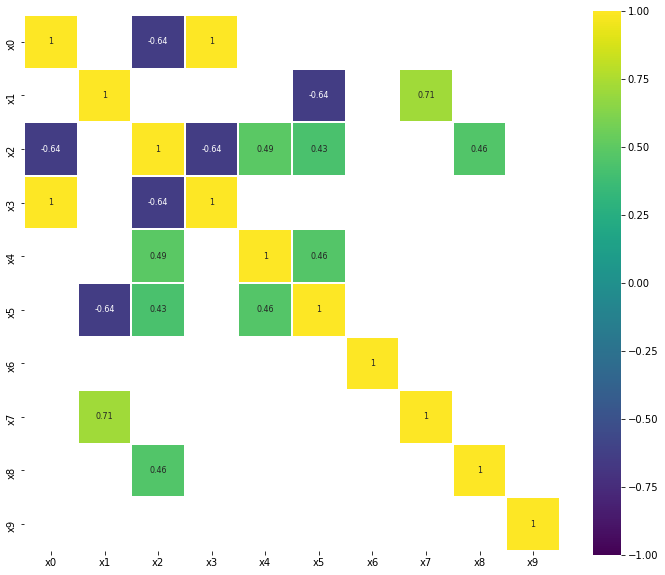

In [5]:
corr = df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr[abs(corr) > 0.4],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

Como podemos ver tempos algumas correlação fortes. Isto pode motivar o uso de modelos que utilizariam essa possível correlação como contribuidor em determinar os grupos.

# Modelling

Embora haja outros modelos que possamos testar, como concluímos na nossa EDA temos um conjunto de variáveis que tem a distribuição Gaussiana. Um modelo muitíssimo apropriado para encontrar grupos mediante um conjunto de normais é chamado de _Modelo de Misturas Gaussiana_ ou, em inglês, _Gaussian Mixture Model_ (GMM).

A idéia dele é de entender que as observações com _p_ features que temos são amostras da mistura de K variáveis Gaussianas Multivariadas sendo que cada uma delas de tamanho _p_. Em especial, essa mistura tem a estrutura de soma ponderada das Gaussianas, onde também estimaremos esses pesos. Também há a questão de que podemos definir estruturas específicas para essa mistura, em especial, sobre sua matriz de covariância. Como na análise de correlação detecta-se algumas correlações muito fortes, suspeita-se de que eles advém de uma matriz de covariância só. Porém, para tirar a dúvida, iremos calcular as métricas em relação a todos os possívels tipos de estrutura de covariância.

In [6]:
def calculate_scores(df, model_obj):
    X = df.copy().values
    
    score_df = pd.DataFrame()
    n_features = df.columns.str.startswith('x').shape[0]
    for cov_type in ['full', 'tied', 'diag', 'spherical']:
        for k in range(2, n_features + 1): 
            model_instance = model_obj(n_components=k,
                                       covariance_type=cov_type)

            clusters = model_instance.fit_predict(X)

            metrics_series = pd.Series({
                'n_clusters': k,
                'cov_type': cov_type,
                's_s': silhouette_score(X, clusters),
                'ch_s': calinski_harabasz_score(X, clusters),
                'db_s': davies_bouldin_score(X, clusters)
            })
        
            score_df = score_df.append(metrics_series, ignore_index=True)
    return score_df

df_score = calculate_scores(df, GaussianMixture)
df_score

,ch_s,cov_type,db_s,n_clusters,s_s
0,1940.042199,full,2.446137,2.0,0.109764
1,981.876801,full,30.933772,3.0,0.037813
2,655.047867,full,24.307838,4.0,0.031783
3,918.028821,full,3.082470,5.0,0.032664
4,1460.231169,full,2.615776,6.0,0.049121
5,1281.985098,full,2.461936,7.0,0.029328
6,1128.341185,full,2.806810,8.0,-0.016013
7,864.993472,full,2.742344,9.0,-0.055523
8,1075.631255,full,2.515946,10.0,-0.018832
9,4344.060748,tied,1.742869,2.0,0.201908


In [7]:
mask = ((df_score['ch_s'] ==  df_score['ch_s'].max()) &
        (df_score['s_s'] == df_score['s_s'].max()))
        
df_score.loc[mask, :]

,ch_s,cov_type,db_s,n_clusters,s_s
27,4516.008036,spherical,1.708171,2.0,0.206333


In [8]:
mask = (df_score['db_s'] == df_score['db_s'].min())
        
df_score.loc[mask, :]

,ch_s,cov_type,db_s,n_clusters,s_s
28,4121.805919,spherical,1.578096,3.0,0.191045


Vemos que os resultados dizem que os hiperparâmetros que maximizam a métrica de _Calinski-Harabasz_ e a métrica de _Silhouette_ é utilizando dois clusters somente.

A diferença para os hiperparâmetros que minimzam a métrica de _Davies-Bouldin_ não é tão grande, então, portanto, iremos dizer que o número de clusters ótimo é 2, sendo o modelo utilizando Mistura Gaussianas considerando as variâncias únicas.

Vemos que a estrutura ótima da matriz de covariância é a **esférica**, Ou seja, de cada uma das Gaussianas Multivariadas foi considerado que cada Gaussiana dentro de uma Gaussiana Multivariada é independentes das demais presentes no vetor aleatório. Além disto, todas elas tem a mesma variância dentro da Gaussiana Multivariada.

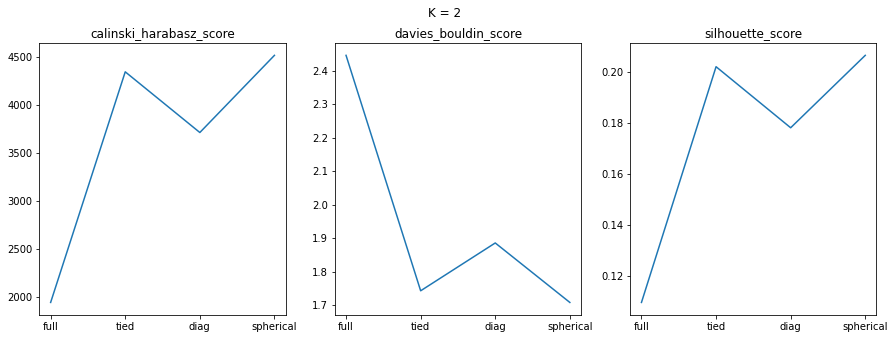

In [31]:
def calculate_scores(df, model_obj):
    X = df.copy().values
    
    score_df = pd.DataFrame()
    n_features = df.columns.str.startswith('x').shape[0]
    for cov_type in ['full', 'tied', 'diag', 'spherical']:
        model_instance = model_obj(n_components=2,
                                   covariance_type=cov_type)

        clusters = model_instance.fit_predict(X)
        
        metrics_series = pd.Series({
            'n_clusters': cov_type,
            's_s': silhouette_score(X, clusters),
            'ch_s': calinski_harabasz_score(X, clusters),
            'db_s': davies_bouldin_score(X, clusters)
        })
        
        score_df = score_df.append(metrics_series, ignore_index=True)

    return score_df
def plot_metrics(score_df, main_title=None):
    fig, axs = plt.subplots(1,3,
                        figsize=(15,5))

    fig.suptitle(main_title)

    axs[0].plot(score_df['n_clusters'],
            score_df['ch_s'])
    axs[0].set_title('calinski_harabasz_score')

    axs[1].plot(score_df['n_clusters'],
            score_df['db_s'])
    axs[1].set_title('davies_bouldin_score')

    axs[2].plot(score_df['n_clusters'],
            score_df['s_s'])
    axs[2].set_title('silhouette_score')
score_df = calculate_scores(df, GaussianMixture)
plot_metrics(score_df, 'K = 2')

Realizando uma compração mais visual do modelo considerando **K = 2**. Veja-se que o modelo com a matriz de variância única e zero correlação entre as Gaussianas é o hiperparâmetro ótimo.

In [37]:
gm = GaussianMixture(n_components=2, covariance_type='spherical')
gm.fit(df)
print("\nMédias do Modelo Estimado \n")
display(gm.means_)
print('\nVariâncias do Modelo Estimado \n')
display(gm.covariances_)
print('\nPesos do Modelo Estimado \n')
display(gm.weights_)


Médias do Modelo Estimado 



array([[-0.02935546, -0.33636814,  3.74745938, -0.02935546,  2.44772545,
         2.52055153,  1.83480713,  0.09904959,  1.1589631 ,  0.57072395],
       [ 1.46535412,  1.23596002,  0.04509978,  1.46535412,  1.04878194,
         0.64739729,  0.74644431,  1.02125396,  0.73245475,  1.11726586]])


Variâncias do Modelo Estimado 



array([2.48597146, 2.62247975])


Pesos do Modelo Estimado 



array([0.48377419, 0.51622581])

## Comparando com outros modelos

Pelo caráter não-supervisionado do problema de clustering, e afim de poder testar outros modelos e comparar os resultados para de fato vermos se as misturam Gaussianas tem resultados ótimos. Rodemos outros modelos em comparação com as Misturas Gaussianas.

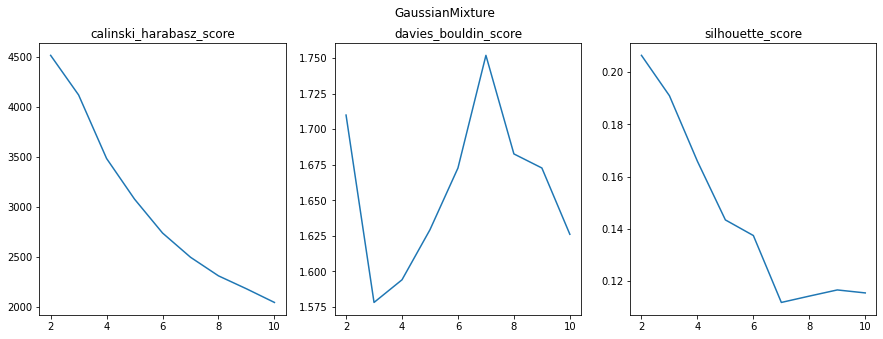

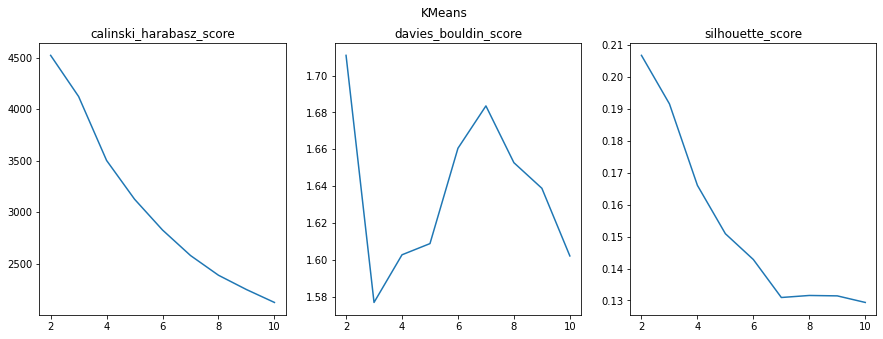

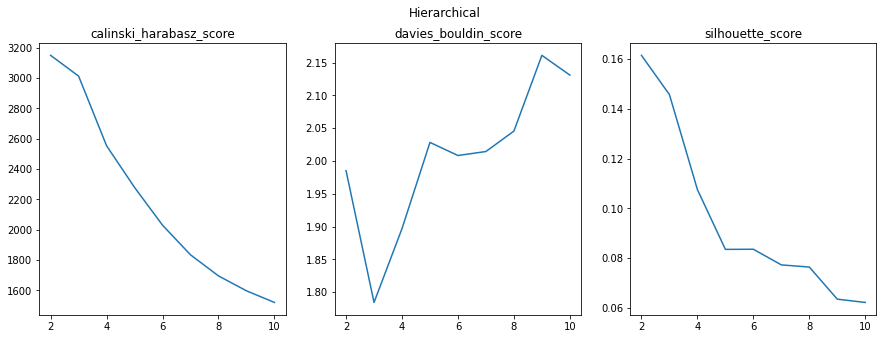

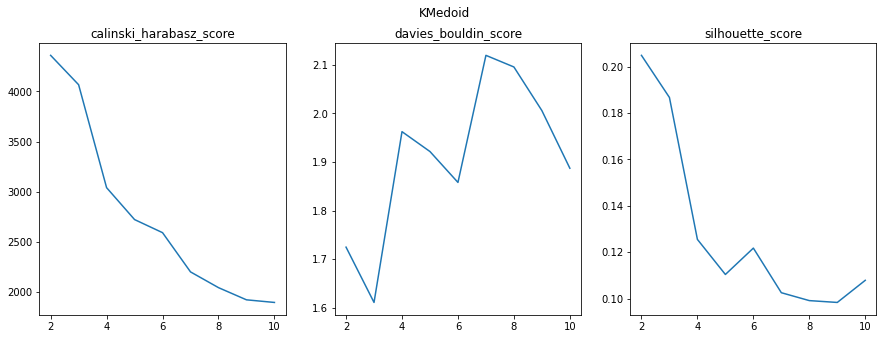

In [10]:
def calculate_scores(df, model_obj):
    X = df.copy().values
    
    score_df = pd.DataFrame()
    n_features = df.columns.str.startswith('x').shape[0]
    for k in range(2, n_features + 1):
        try:
            model_instance = model_obj(n_clusters=k)
        except:
            model_instance = model_obj(n_components=k,
                                      covariance_type='spherical')

        clusters = model_instance.fit_predict(X)
        
        metrics_series = pd.Series({
            'n_clusters': k,
            's_s': silhouette_score(X, clusters),
            'ch_s': calinski_harabasz_score(X, clusters),
            'db_s': davies_bouldin_score(X, clusters)
        })
        
        score_df = score_df.append(metrics_series, ignore_index=True)

    return score_df

def plot_metrics(score_df, main_title):
    fig, axs = plt.subplots(1,3,
                        figsize=(15,5))

    fig.suptitle(main_title)

    axs[0].plot(score_df['n_clusters'],
            score_df['ch_s'])
    axs[0].set_title('calinski_harabasz_score')

    axs[1].plot(score_df['n_clusters'],
            score_df['db_s'])
    axs[1].set_title('davies_bouldin_score')

    axs[2].plot(score_df['n_clusters'],
            score_df['s_s'])
    axs[2].set_title('silhouette_score')

dict_model = {
    'GaussianMixture': GaussianMixture,
    'KMeans': KMeans,
    'Hierarchical': AgglomerativeClustering,
    'KMedoid': KMedoids
}

for model_name, model in dict_model.items():
    score_df = calculate_scores(df, model)
    plot_metrics(score_df, model_name)

Vemos que os demais modelos perfomaram parecido com a GMM. Ainda assim, optou-se pelo o uso da GMM pela sua questão interpretativa que melhor reflete o caráter dos dados.